In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/BrainTumourTraining(Dataset1).zip" -d /content/
!unzip "/content/drive/MyDrive/BrainTumourTesting(Dataset2).zip" -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/BrainTumourTraining(Dataset1)/pituitary/Tr-pi_0864.jpg  
  inflating: /content/BrainTumourTraining(Dataset1)/pituitary/Tr-pi_0865.jpg  
  inflating: /content/BrainTumourTraining(Dataset1)/pituitary/Tr-pi_0866.jpg  
  inflating: /content/BrainTumourTraining(Dataset1)/pituitary/Tr-pi_0867.jpg  
  inflating: /content/BrainTumourTraining(Dataset1)/pituitary/Tr-pi_0868.jpg  
  inflating: /content/BrainTumourTraining(Dataset1)/pituitary/Tr-pi_0869.jpg  
  inflating: /content/BrainTumourTraining(Dataset1)/pituitary/Tr-pi_0870.jpg  
  inflating: /content/BrainTumourTraining(Dataset1)/pituitary/Tr-pi_0871.jpg  
  inflating: /content/BrainTumourTraining(Dataset1)/pituitary/Tr-pi_0872.jpg  
  inflating: /content/BrainTumourTraining(Dataset1)/pituitary/Tr-pi_0873.jpg  
  inflating: /content/BrainTumourTraining(Dataset1)/pituitary/Tr-pi_0874.jpg  
  inflating: /content/BrainTumourTraining(Dataset1)/pituitary/Tr-pi_0875.jpg  
 

In [ ]:
!pip install timm # provides collection of cv models, optimisers and other utilities


In [ ]:
import torch
import timm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
import seaborn as sns
import copy
import os
import json
import random
from datetime import datetime

In [ ]:
#define transformation pipeline
transform = transforms.Compose([
    transforms.Resize(256),                                  # Keep aspect ratio
    transforms.RandomRotation(degrees=15),                   # Small rotations for robustness
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),     # Slight scale jitter
    transforms.Grayscale(num_output_channels=3),             # Convert MRI to RGB-like
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),    # Slight intensity variations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.01 if random.random() < 0.3 else x) # light noise
])


In [ ]:
#load dataset
dataset = datasets.ImageFolder('/content/BrainTumourTraining(Dataset1)', transform=transform)
class_names = dataset.classes
print(class_names)
print(f"Number of training samples: {len(dataset)}")


['glioma', 'meningioma', 'notumor', 'pituitary']
Number of training samples: 5712


In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
def create_model():
    """Create and return a fresh model instance"""
    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    model.head = nn.Linear(model.head.in_features, 4)
    print('model created')
    print(f'activation: model.blocks[0].mlp.act')
    return model.to(device)


## Training Loop

In [ ]:

def train_fold(model, train_loader, val_loader, epochs=5, lr=3e-5):
    """Train model for one fold"""
    class_weights = torch.tensor([1.0, 1.0, 1.0, 1.2]).to(device)
    loss_func = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_func(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

    # Return the best validation accuracy achieved
    best_val_accuracy = max(val_accuracies)
    return train_losses, val_accuracies, best_val_accuracy

In [ ]:
def evaluate_model(model, test_loader, class_names, device, fold_num=None):
    """Evaluate model and return predictions, labels, and probabilities"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels)) * 100

    if fold_num is not None:
        print(f"\nFold {fold_num} Results:")
        print("="*30)
    else:
        print(f"\nTest Set Results:")
        print("="*30)

    print(f"Accuracy: {accuracy:.2f}%")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return np.array(all_preds), np.array(all_labels), np.array(all_probs), accuracy


In [ ]:
def plot_confusion_matrix(labels, preds, class_names, title="Confusion Matrix"):
    """Plot confusion matrix"""
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
# Cross-Validation Setup
def cross_validation(dataset, k_folds=5, epochs=5, batch_size=32, lr=3e-5):
    """Perform k-fold cross validation"""
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    cv_results = {
        'fold_accuracies': [],
        'fold_predictions': [],
        'fold_labels': [],
        'fold_probabilities': [],
        'train_losses_per_fold': [],
        'val_accuracies_per_fold': []
    }

    # Get indices for cross-validation
    dataset_indices = list(range(len(dataset)))

    print(f"Starting {k_folds}-Fold Cross Validation")
    print("="*50)

    for fold, (train_indices, val_indices) in enumerate(kfold.split(dataset_indices)):
        print(f"\nFold {fold + 1}/{k_folds}")
        print("-" * 30)

        # Create data subsets for this fold
        train_subset = Subset(dataset, train_indices)
        val_subset = Subset(dataset, val_indices)

        # Create data loaders
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        # Create fresh model for this fold
        model = create_model()

        # Train the model
        train_losses, val_accuracies = train_fold(model, train_loader, val_loader, epochs, lr)

        # Evaluate on validation set
        preds, labels, probs, accuracy = evaluate_model(model, val_loader, class_names, device, fold + 1)

        # Store results
        cv_results['fold_accuracies'].append(accuracy)
        cv_results['fold_predictions'].append(preds)
        cv_results['fold_labels'].append(labels)
        cv_results['fold_probabilities'].append(probs)
        cv_results['train_losses_per_fold'].append(train_losses)
        cv_results['val_accuracies_per_fold'].append(val_accuracies)

    return cv_results


In [ ]:
def analyze_cv_results(cv_results, class_names):
    """Analyze and visualize cross-validation results"""
    fold_accuracies = cv_results['fold_accuracies']

    print(f"\nCross-Validation Results Summary")
    print("="*50)
    print(f"Mean Accuracy: {np.mean(fold_accuracies):.2f}% ± {np.std(fold_accuracies):.2f}%")
    print(f"Min Accuracy: {np.min(fold_accuracies):.2f}%")
    print(f"Max Accuracy: {np.max(fold_accuracies):.2f}%")

    # Plot accuracy across folds
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(fold_accuracies) + 1), fold_accuracies)
    plt.axhline(y=np.mean(fold_accuracies), color='r', linestyle='--',
                label=f'Mean: {np.mean(fold_accuracies):.2f}%')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy Across Folds')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot training curves
    plt.subplot(1, 2, 2)
    for i, (train_losses, val_accs) in enumerate(zip(cv_results['train_losses_per_fold'],
                                                    cv_results['val_accuracies_per_fold'])):
        plt.plot(val_accs, alpha=0.7, label=f'Fold {i+1}')

    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy (%)')
    plt.title('Validation Accuracy Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Aggregate confusion matrix
    all_preds = np.concatenate(cv_results['fold_predictions'])
    all_labels = np.concatenate(cv_results['fold_labels'])
    plot_confusion_matrix(all_labels, all_preds, class_names,
                         title="Aggregated Confusion Matrix (Cross-Validation)")

In [ ]:
def train_final_model_and_test(dataset, test_dataset, class_names, epochs=5, batch_size=32, lr=3e-5):
    """Train final model on full training set and evaluate on test set"""
    print(f"\nTraining Final Model on Full Training Set")
    print("="*50)

    # Use 90% for training, 10% for validation
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Create and train final model
    final_model = create_model()
    train_losses, val_accuracies = train_fold(final_model, train_loader, val_loader, epochs, lr)

    # Evaluate on test set
    print(f"\nFinal Test Set Evaluation:")
    test_preds, test_labels, test_probs, test_accuracy = evaluate_model(
        final_model, test_loader, class_names, device)

    # Plot final confusion matrix
    plot_confusion_matrix(test_labels, test_preds, class_names,
                         title="Final Test Set Confusion Matrix")

    return final_model, test_accuracy


In [ ]:

def nested_cross_validation_with_lr_search(dataset, lr_candidates, k_folds=5, epochs=5, batch_size=32):
    """
    Approach 2: Nested cross-validation with inner loop for LR selection
    """
    print(f"Nested CV with LR search: {lr_candidates}")
    print("="*60)

    outer_kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    dataset_indices = list(range(len(dataset)))

    outer_fold_results = []
    selected_lrs = []

    for outer_fold, (train_val_indices, test_indices) in enumerate(outer_kfold.split(dataset_indices)):
        print(f"\nOuter Fold {outer_fold + 1}/{k_folds}")
        print("-" * 40)

        # Split train_val into train and validation for inner CV
        train_val_subset = [dataset_indices[i] for i in train_val_indices]
        inner_kfold = KFold(n_splits=3, shuffle=True, random_state=42)  # Fewer folds for inner CV

        # Test each learning rate using inner CV
        lr_scores = {}
        for lr in lr_candidates:
            inner_fold_accuracies = []

            for inner_fold, (inner_train_idx, inner_val_idx) in enumerate(inner_kfold.split(train_val_subset)):
                # Get actual dataset indices
                inner_train_indices = [train_val_subset[i] for i in inner_train_idx]
                inner_val_indices = [train_val_subset[i] for i in inner_val_idx]

                # Create data subsets
                inner_train_subset = Subset(dataset, inner_train_indices)
                inner_val_subset = Subset(dataset, inner_val_indices)

                # Create data loaders
                inner_train_loader = DataLoader(inner_train_subset, batch_size=batch_size, shuffle=True)
                inner_val_loader = DataLoader(inner_val_subset, batch_size=batch_size, shuffle=False)

                # Train model with current LR
                model = create_model()
                _, _, best_val_acc = train_fold(model, inner_train_loader, inner_val_loader, epochs, lr)
                inner_fold_accuracies.append(best_val_acc)

            lr_scores[lr] = np.mean(inner_fold_accuracies)
            print(f"    LR {lr}: Inner CV Accuracy = {lr_scores[lr]:.2f}%")

        # Select best LR for this outer fold
        best_lr_for_fold = max(lr_scores.keys(), key=lambda x: lr_scores[x])
        selected_lrs.append(best_lr_for_fold)
        print(f"  Selected LR for outer fold {outer_fold + 1}: {best_lr_for_fold}")

        # Train final model on full train_val set with best LR and evaluate on test set
        train_val_subset_data = Subset(dataset, train_val_indices)
        test_subset_data = Subset(dataset, test_indices)

        train_val_loader = DataLoader(train_val_subset_data, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_subset_data, batch_size=batch_size, shuffle=False)

        final_model = create_model()
        _, _, _ = train_fold(final_model, train_val_loader, test_loader, epochs, best_lr_for_fold)

        # Evaluate on test set
        test_preds, test_labels, test_probs, test_accuracy = evaluate_model(
            final_model, test_loader, class_names, device, outer_fold + 1
        )
        outer_fold_results.append(test_accuracy)
        print(f"  Test Accuracy for outer fold {outer_fold + 1}: {test_accuracy:.2f}%")

    final_accuracy = np.mean(outer_fold_results)
    final_std = np.std(outer_fold_results)
    most_common_lr = max(set(selected_lrs), key=selected_lrs.count)

    print(f"\nNested CV Results:")
    print(f"Final Accuracy: {final_accuracy:.2f}% ± {final_std:.2f}%")
    print(f"Most frequently selected LR: {most_common_lr}")
    print(f"LR selections per fold: {selected_lrs}")

    return final_accuracy, most_common_lr, selected_lrs, outer_fold_results

In [ ]:
LR_CANDIDATES = [1e-5, 3e-5, 5e-5, 1e-4, 3e-4]

print("\n" + "="*80)
print("Starting Nested Cross-Validation")
final_accuracy, best_lr_nested, lr_selections, fold_results = nested_cross_validation_with_lr_search(
    dataset,
    LR_CANDIDATES,
    k_folds=5,
    epochs=3,
    batch_size=32
)

print(f"Best lr = {best_lr_nested}")


Starting Nested Cross-Validation
Nested CV with LR search: [1e-05, 3e-05, 5e-05, 0.0001, 0.0003]

Outer Fold 1/5
----------------------------------------
    LR 1e-05: Inner CV Accuracy = 97.44%
    LR 3e-05: Inner CV Accuracy = 95.49%
    LR 5e-05: Inner CV Accuracy = 96.89%
    LR 0.0001: Inner CV Accuracy = 93.96%
    LR 0.0003: Inner CV Accuracy = 78.00%
  Selected LR for outer fold 1: 1e-05

Fold 1 Results:
Accuracy: 97.64%

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.95      0.97       288
  meningioma       0.96      0.96      0.96       265
     notumor       0.97      1.00      0.99       291
   pituitary       0.98      0.99      0.99       299

    accuracy                           0.98      1143
   macro avg       0.98      0.98      0.98      1143
weighted avg       0.98      0.98      0.98      1143

  Test Accuracy for outer fold 1: 97.64%

Outer Fold 2/5
----------------------------------------
    LR 1e

In [ ]:

# Hyperparameters
K_FOLDS = 5
EPOCHS = 2
BATCH_SIZE = 32
LEARNING_RATE = 3e-5

# Perform cross-validation
cv_results = cross_validation(dataset, k_folds=K_FOLDS, epochs=EPOCHS,
                                 batch_size=BATCH_SIZE, lr=LEARNING_RATE)


Starting 3-Fold Cross Validation

Fold 1/3
------------------------------


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

KeyboardInterrupt: 


Cross-Validation Results Summary
Mean Accuracy: 95.66% ± 1.90%
Min Accuracy: 93.07%
Max Accuracy: 97.58%


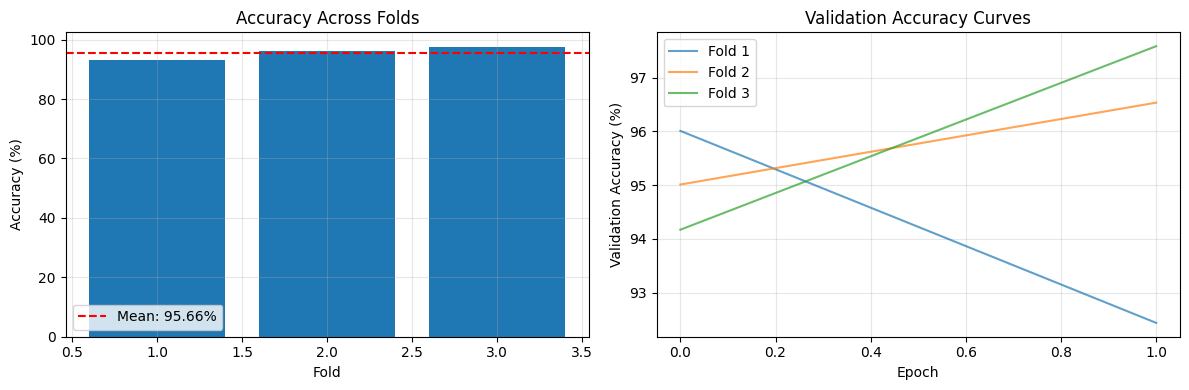

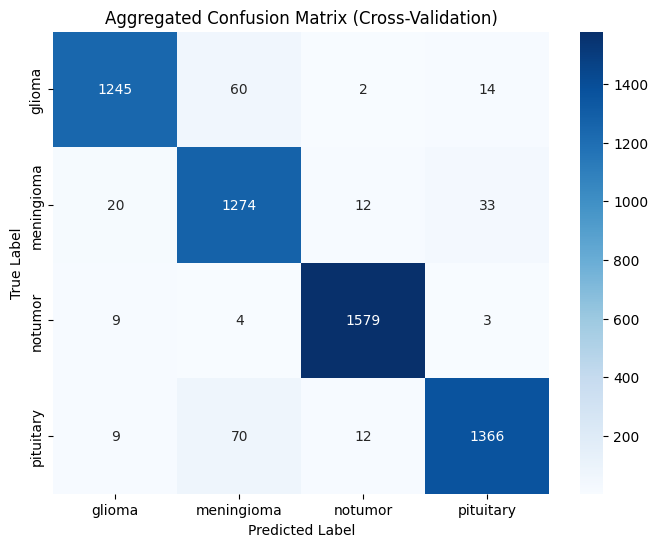

In [ ]:
# Analyze results
analyze_cv_results(cv_results, class_names)


Training Final Model on Full Training Set
Epoch 1/2 - Train Loss: 0.2543, Val Acc: 97.55%
Epoch 2/2 - Train Loss: 0.0849, Val Acc: 98.08%

Final Test Set Evaluation:

Test Set Results:
Accuracy: 97.77%

Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.93      0.95       672
  meningioma       0.96      1.00      0.98      1100
     notumor       1.00      0.98      0.99      2000
   pituitary       0.95      0.99      0.97       629

    accuracy                           0.98      4401
   macro avg       0.97      0.97      0.97      4401
weighted avg       0.98      0.98      0.98      4401



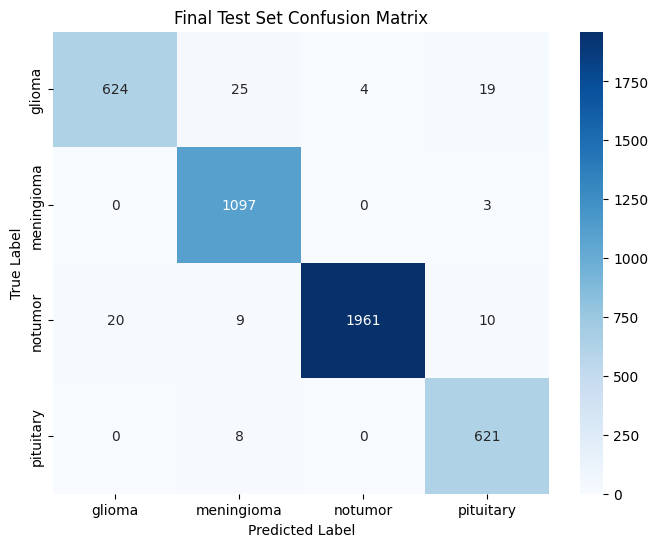


Summary:
Cross-Validation Mean Accuracy: 95.66% ± 1.90%
Final Test Set Accuracy: 97.77%


In [ ]:
# Train final model and test
final_model, test_accuracy = train_final_model_and_test(
                              dataset, test_dataset, class_names, epochs=EPOCHS,
                              batch_size=BATCH_SIZE, lr=LEARNING_RATE)

#save model to drive
torch.save(final_model.state_dict(), '/content/drive/MyDrive/vit_brain_tumor_v2.pth')

print(f"\nSummary:")
print("="*50)
print(f"Cross-Validation Mean Accuracy: {np.mean(cv_results['fold_accuracies']):.2f}% ± {np.std(cv_results['fold_accuracies']):.2f}%")
print(f"Final Test Set Accuracy: {test_accuracy:.2f}%")

Just Test without train

In [ ]:
import timm
from google.colab import drive

drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/BrainTumourTesting(Dataset2).zip" -d /content/



Mounted at /content/drive
Archive:  /content/drive/MyDrive/BrainTumourTesting(Dataset2).zip
   creating: /content/BrainTumourTesting(Dataset2)/
   creating: /content/BrainTumourTesting(Dataset2)/glioma/
  inflating: /content/BrainTumourTesting(Dataset2)/glioma/glioma (1).jpg  
  inflating: /content/BrainTumourTesting(Dataset2)/glioma/glioma (10).jpg  
  inflating: /content/BrainTumourTesting(Dataset2)/glioma/glioma (100).jpg  
  inflating: /content/BrainTumourTesting(Dataset2)/glioma/glioma (101).jpg  
  inflating: /content/BrainTumourTesting(Dataset2)/glioma/glioma (102).jpg  
  inflating: /content/BrainTumourTesting(Dataset2)/glioma/glioma (103).jpg  
  inflating: /content/BrainTumourTesting(Dataset2)/glioma/glioma (104).jpg  
  inflating: /content/BrainTumourTesting(Dataset2)/glioma/glioma (105).jpg  
  inflating: /content/BrainTumourTesting(Dataset2)/glioma/glioma (106).jpg  
  inflating: /content/BrainTumourTesting(Dataset2)/glioma/glioma (107).jpg  
  inflating: /content/BrainTum

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset

print("=== DIAGNOSTIC INFO ===")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create model architecture
model = timm.create_model('vit_base_patch16_224', pretrained=False)
model.head = torch.nn.Linear(model.head.in_features, 4)

# Load the saved weights
model.load_state_dict(torch.load('/content/drive/MyDrive/vit_brain_tumor_v2.pth', map_location=device))
model = model.to(device)
model.eval()

print(f"Model device: {next(model.parameters()).device}")
print(f"Model training mode: {model.training}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

=== DIAGNOSTIC INFO ===
CUDA available: False
Device: cpu
Model device: cpu
Model training mode: False
Total parameters: 85,801,732


In [ ]:
# Load test dataset
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder('/content/BrainTumourTesting(Dataset2)', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
class_names = test_dataset.classes

print(f"Test dataset size: {len(test_dataset)}")
print(f"Number of batches: {len(test_loader)}")
print(f"Batch size: {test_loader.batch_size}")
print(f"Classes: {class_names}")

Test dataset size: 4401
Number of batches: 138
Batch size: 32
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


**Perform Transform
**

In [ ]:
import time
# Test single batch timing
print("\n=== SINGLE BATCH TEST ===")
with torch.no_grad():
    start = time.time()
    inputs, labels = next(iter(test_loader))
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    end = time.time()
    print(f"Single batch ({inputs.shape[0]} images) processing time: {end-start:.2f}s")

print("\n=== FULL EVALUATION ===")
model.eval()
all_preds = []
all_labels = []
all_probs = []

start_time = time.time()
with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(test_loader):
        batch_start = time.time()

        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

        batch_time = time.time() - batch_start

        # Print progress every 10 batches
        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}/{len(test_loader)}: {batch_time:.2f}s")

        # Early exit for testing (remove this after confirming it works)
        if batch_idx >= 5:  # Process only first 6 batches for testing
            print("Early exit for testing...")
            break

total_time = time.time() - start_time
print(f"Total processing time: {total_time:.2f}s")

# Calculate metrics AFTER processing all batches
accuracy = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
print(f"Accuracy (partial): {accuracy:.2f}%")

print("Classes in predictions:", np.unique(all_preds))
print("Classes in labels:", np.unique(all_labels))



=== SINGLE BATCH TEST ===
Single batch (32 images) processing time: 23.21s

=== FULL EVALUATION ===
Batch 0/138: 22.49s
Early exit for testing...
Total processing time: 137.85s
Accuracy (partial): 98.96%
Classes in predictions: [0 1]
Classes in labels: [0]


In [ ]:
import math
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.cm as cm
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class ViTAttentionMap:
    def __init__(self, model):
        self.model = model
        last_block = self.model.blocks[-1]
        self.attn_obj = last_block.attn
        self.attn_obj.fused_attn = False  # Disable fused_attn to compute explicit attention
        self.original_forward = self.attn_obj.forward
        self.attn_obj.forward = self.my_forward_wrapper(self.attn_obj)
        self.grid_size = int(math.sqrt(self.model.patch_embed.num_patches))

    def my_forward_wrapper(self, attn_obj):
        def my_forward(x, attn_mask=None):
            B, N, C = x.shape
            qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, attn_obj.head_dim).permute(2, 0, 3, 1, 4)
            q, k, v = qkv.unbind(0)

            # Handle qk_norm if enabled
            if hasattr(attn_obj, 'q_norm') and attn_obj.q_norm is not None:
                q = attn_obj.q_norm(q.reshape(B * attn_obj.num_heads, N, attn_obj.head_dim)).reshape(B, attn_obj.num_heads, N, attn_obj.head_dim)
            if hasattr(attn_obj, 'k_norm') and attn_obj.k_norm is not None:
                k = attn_obj.k_norm(k.reshape(B * attn_obj.num_heads, N, attn_obj.head_dim)).reshape(B, attn_obj.num_heads, N, attn_obj.head_dim)

            q = q * attn_obj.scale
            attn = q @ k.transpose(-2, -1)

            if attn_mask is not None:
                attn += attn_mask

            attn = attn.softmax(dim=-1)

            # Store attention map after softmax, before drop
            attn_obj.attn_map = attn
            attn_obj.cls_attn_map = attn[:, :, 0, 1:]  # [B, heads, num_patches]

            attn = attn_obj.attn_drop(attn)
            x = (attn @ v).transpose(1, 2).reshape(B, N, C)
            x = attn_obj.proj(x)
            x = attn_obj.proj_drop(x)
            return x
        return my_forward

    def __call__(self, input_tensor):
        _ = self.model(input_tensor)
        # Get cls_attn_map [B, heads, num_patches]
        cls_attn = self.attn_obj.cls_attn_map
        # Average over heads
        cls_attn = cls_attn.mean(dim=1)[0]  # [num_patches]
        # Reshape to grid
        attn_map = cls_attn.view(self.grid_size, self.grid_size)
        # Interpolate to 224x224
        attn_map = F.interpolate(
            attn_map.unsqueeze(0).unsqueeze(0),
            size=(224, 224),
            mode='bilinear',
            align_corners=False
        ).squeeze()
        # Normalize
        attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-8)
        return attn_map.detach().cpu().numpy()

def denormalize_tensor(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    return tensor * std + mean

def tensor_to_pil(tensor):
    denorm = denormalize_tensor(tensor)
    denorm = torch.clamp(denorm, 0, 1)
    # Convert to PIL Image
    img_np = (denorm.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    return Image.fromarray(img_np)

def get_overlaid_image(original_img, heatmap, alpha=0.4):
    # Convert PIL Image to numpy if needed
    if isinstance(original_img, Image.Image):
        orig_np = np.array(original_img) / 255.0
    else:
        orig_np = original_img

    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap_img = Image.fromarray(np.uint8(jet_heatmap * 255))

    # Get the size from original image
    if isinstance(original_img, Image.Image):
        target_size = original_img.size
    else:
        target_size = (original_img.shape[1], original_img.shape[0])  # PIL uses (width, height)

    jet_heatmap_img = jet_heatmap_img.resize(target_size, Image.BILINEAR)
    jet_heatmap_np = np.array(jet_heatmap_img) / 255.0
    superimposed_np = jet_heatmap_np * alpha + orig_np * (1 - alpha)
    superimposed_img = Image.fromarray(np.uint8(superimposed_np * 255))
    return superimposed_img

def show_predictions(model, data_loader, device, class_names, num=8):
    model.eval()
    images, labels, preds = [], [], []
    attention = ViTAttentionMap(model)

    with torch.no_grad():
        for inputs, lbls in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            images.extend(inputs.cpu())
            labels.extend(lbls)
            preds.extend(predicted.cpu())
            if len(images) >= num:
                break

    plt.figure(figsize=(16, 8))
    for i in range(min(num, len(images))):
        plt.subplot(2, 4, i + 1)

        original_pil = tensor_to_pil(images[i])

        transformed_tensor = transform(original_pil).unsqueeze(0).to(device)
        attn_map = attention(transformed_tensor)

        overlaid_img = get_overlaid_image(original_pil, attn_map)

        plt.imshow(overlaid_img)
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_predictions(model, test_loader, device, class_names)

NameError: name 'model' is not defined